### Airbnb Listing EDA
    Author      :   Mareez Adel
    Date        :   15 Sep,2024
    Project     :   Customer Segmentation for E-commerce Personalization

---

This project involves the use of K-means clustering and PCA (Principal Component Analysis) for performing customer segmentation based on purchasing behavior within an e-commerce dataset. The aim is to discover distinct groups of customers with similar preferences and behaviors to enable personalized marketing strategies and recommendations.

---

Key Features:
- Customer Segmentation & Profiling

- Data Preprocessing & Feature Engineering

- Dimensionality Reduction & Clustering

- Visualization & Evaluation

- Recommendations and Insights

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

### Import Data

In [4]:
df = pd.read_excel('Data/Online Retail.xlsx')

In [5]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


### Data Preprocessing

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


#### Drop Missing Values

In [7]:
df.dropna(subset=['CustomerID'], inplace=True)

#### Drop Deleted Orders

In [8]:
df = df[df['Quantity'] > 0]

#### Drop Duplicated Values

In [9]:
df.duplicated().sum()

5192

In [10]:
df.drop_duplicates(inplace=True)

C:\Users\reeza\AppData\Local\Temp\ipykernel_21116\3006716147.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(inplace=True)


#### Feature Engineering

In [11]:
df['Total_Spending'] = df['Quantity'] * df['UnitPrice']

C:\Users\reeza\AppData\Local\Temp\ipykernel_21116\2458156012.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Total_Spending'] = df['Quantity'] * df['UnitPrice']


In [12]:
customer_df = df.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',  # Order frequency
    'Quantity': 'sum',       # Total quantity bought
    'Total_Spending': 'sum', # Total spending
}).reset_index()

customer_df.columns = ['CustomerID', 'OrderFrequency', 'TotalQuantity', 'TotalSpending']

In [13]:
customer_df

,CustomerID,OrderFrequency,TotalQuantity,TotalSpending
0,12346.0,1,74215,77183.60
1,12347.0,7,2458,4310.00
2,12348.0,4,2341,1797.24
3,12349.0,1,631,1757.55
4,12350.0,1,197,334.40
...,...,...,...,...
4334,18280.0,1,45,180.60
4335,18281.0,1,54,80.82
4336,18282.0,2,103,178.05
4337,18283.0,16,1357,2045.53


#### Handle Outliers

In [14]:
def remove_outliers(df, columns):
    Q1 = df[columns].quantile(0.25)
    Q3 = df[columns].quantile(0.75)
    IQR = Q3 - Q1
    df_cleaned = df[~((df[columns] < (Q1 - 1.5 * IQR)) | (df[columns] > (Q3 + 1.5 * IQR))).any(axis=1)]
    return df_cleaned

columns_to_check = ['OrderFrequency', 'TotalQuantity', 'TotalSpending']
customer_df = remove_outliers(customer_df, columns_to_check)

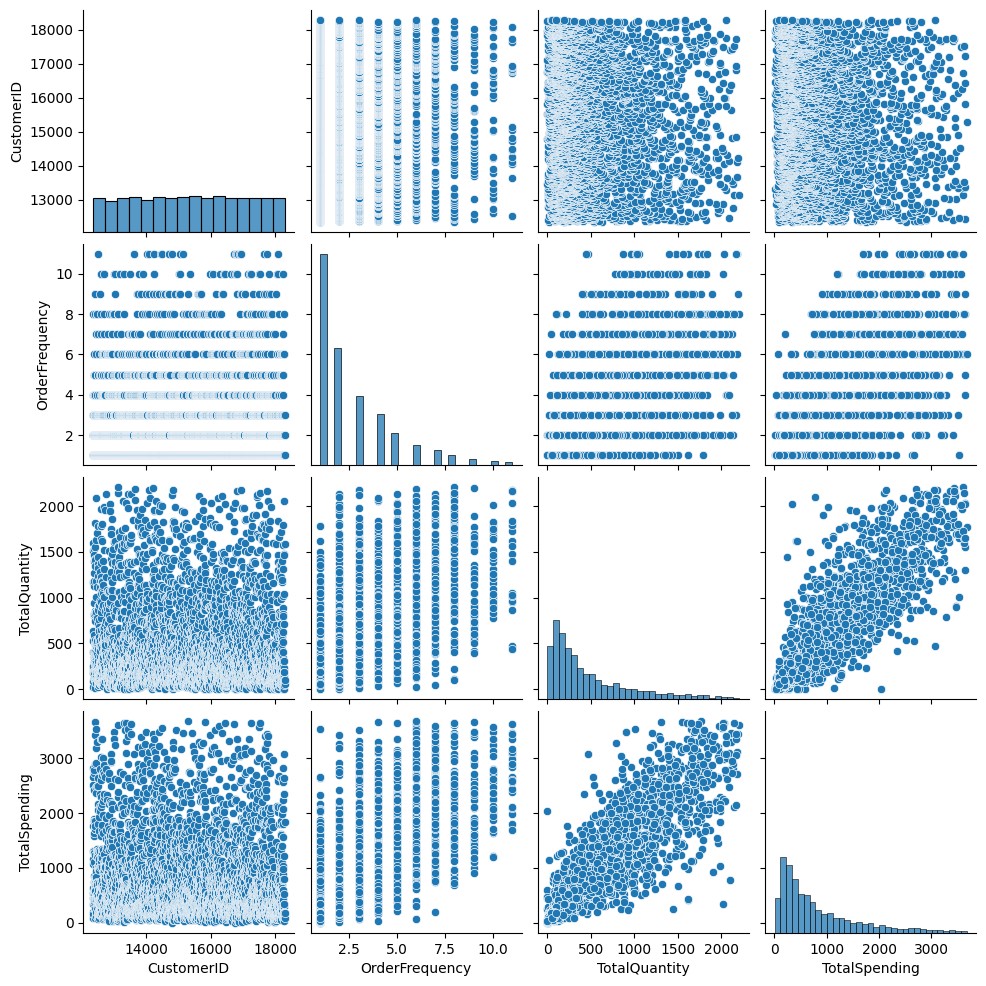

In [15]:
sns.pairplot(customer_df)

### Dimensionality Reduction

In [16]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_df[['OrderFrequency', 'TotalQuantity', 'TotalSpending']])

In [17]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

### Clustering

#### optimal number of clusters using the elbow method

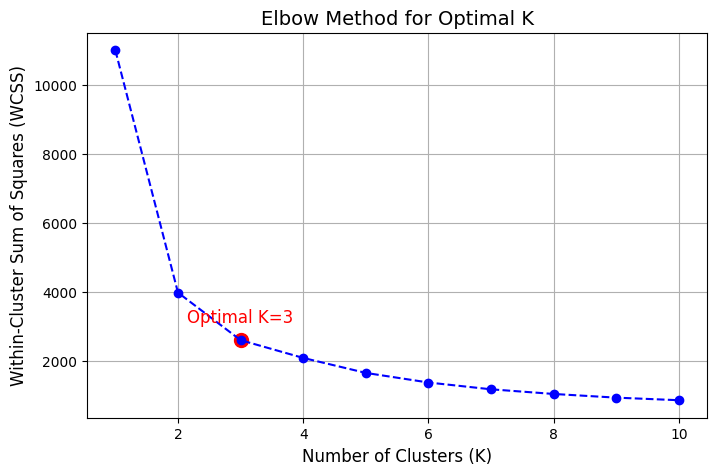

In [18]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(pca_features)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--', color='b', label='WCSS')

optimal_k = 3
plt.scatter(optimal_k, wcss[optimal_k-1], color='red', s=100)  # Mark the elbow
plt.title('Elbow Method for Optimal K', fontsize=14)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Within-Cluster Sum of Squares (WCSS)', fontsize=12)
plt.grid(True)
plt.text(optimal_k, wcss[optimal_k-1] + 500, f'Optimal K={optimal_k}', color='red', fontsize=12, ha='center')

plt.show()

### Clustering without PCA

C:\Users\reeza\AppData\Local\Temp\ipykernel_21116\4255567639.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_df['Cluster'] = cluster_labels


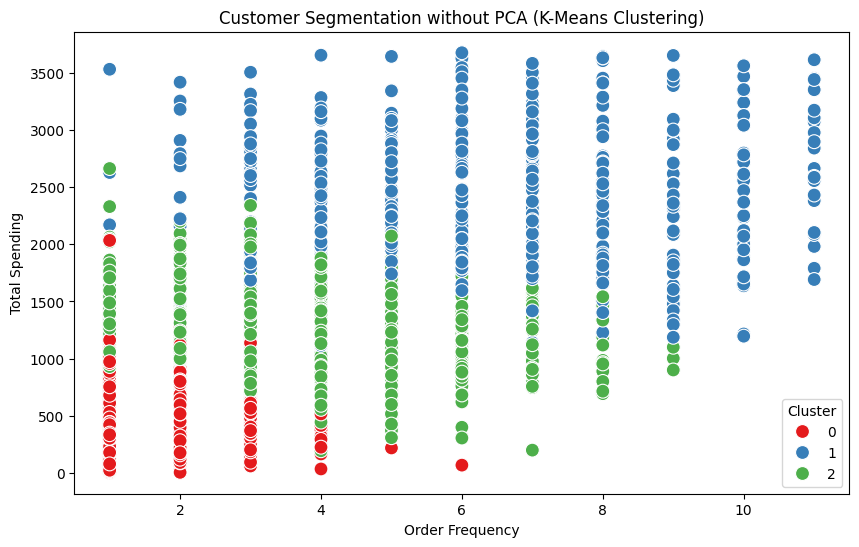

In [19]:
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_features)

customer_df['Cluster'] = cluster_labels

plt.figure(figsize=(10, 6))
sns.scatterplot(x='OrderFrequency', y='TotalSpending', hue='Cluster', data=customer_df, palette='Set1', s=100)
plt.title('Customer Segmentation without PCA (K-Means Clustering)')
plt.xlabel('Order Frequency')
plt.ylabel('Total Spending')
plt.legend(title='Cluster')
plt.show()


#### Evaluation: Silhouette Score

In [20]:
sil_score_no_pca = silhouette_score(scaled_features, cluster_labels)
print(f'Silhouette Score (Without PCA): {sil_score_no_pca:.4f}')

Silhouette Score (Without PCA): 0.4950


### Clustering with PCA

In [21]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(pca_features)

customer_df['Cluster'] = cluster_labels

C:\Users\reeza\AppData\Local\Temp\ipykernel_21116\652111648.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_df['Cluster'] = cluster_labels


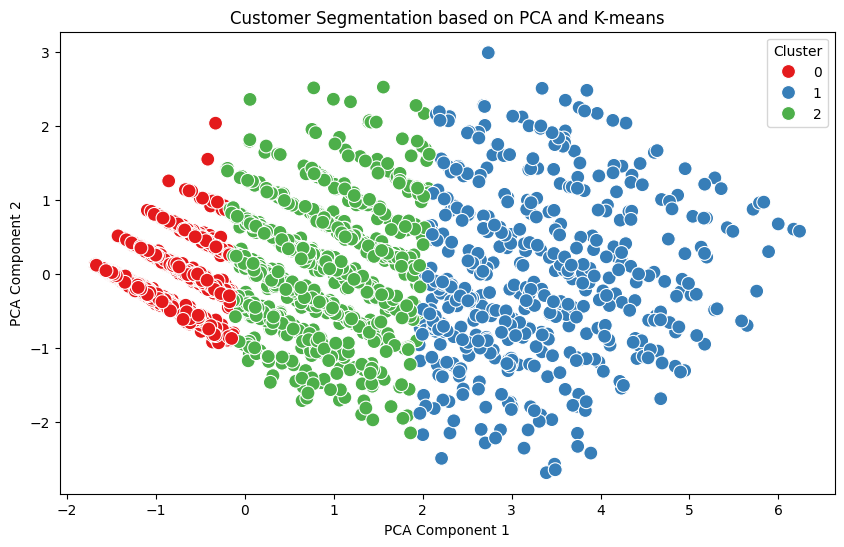

In [22]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=cluster_labels, palette='Set1', s=100)
plt.title('Customer Segmentation based on PCA and K-means')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

#### Evaluation: Silhouette Score

In [23]:
sil_score_pca = silhouette_score(pca_features, cluster_labels)
print(f'Silhouette Score (With PCA): {sil_score_pca:.4f}')

Silhouette Score (With PCA): 0.5206


In [24]:
# Profiling clusters
cluster_profile = customer_df.groupby('Cluster').agg({
    'OrderFrequency': 'mean',
    'TotalQuantity': 'mean',
    'TotalSpending': 'mean'
}).reset_index()

print(cluster_profile)

   Cluster  OrderFrequency  TotalQuantity  TotalSpending
0        0        1.488869     201.297250     357.873427
1        1        6.352705    1403.426854    2386.881144
2        2        3.682759     677.687685    1139.582060


###  Personalization and Recommendations

In [25]:
def personalized_recommendation(cluster):
    if cluster == 0:  # Budget Buyers
        return 'Offer discounts on budget-friendly items'
    elif cluster == 1:  # Loyal Customers
        return 'Recommend premium products with exclusive offers'
    elif cluster == 2:  # Occasional Shoppers
        return 'Suggest complementary products for cross-sell'

customer_df['Recommendation'] = customer_df['Cluster'].apply(personalized_recommendation)


C:\Users\reeza\AppData\Local\Temp\ipykernel_21116\1943591723.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_df['Recommendation'] = customer_df['Cluster'].apply(personalized_recommendation)


### Interpretation and Insights:

In [26]:
def customer_retention_strategy(cluster):
    if cluster == 0:  # Budget Buyers
        return 'Send promotional offers and discounts to encourage more purchases'
    elif cluster == 1:  # Loyal Customers
        return 'Offer loyalty programs and exclusive deals to retain high-value customers'
    elif cluster == 2:  # Occasional Shoppers
        return 'Suggest cross-sell and complementary products to boost average order value'

customer_df['RetentionStrategy'] = customer_df['Cluster'].apply(customer_retention_strategy)


C:\Users\reeza\AppData\Local\Temp\ipykernel_21116\3213823345.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_df['RetentionStrategy'] = customer_df['Cluster'].apply(customer_retention_strategy)


In [27]:
customer_df

,CustomerID,OrderFrequency,TotalQuantity,TotalSpending,Cluster,Recommendation,RetentionStrategy
3,12349.0,1,631,1757.55,2,Suggest complementary products for cross-sell,Suggest cross-sell and complementary products ...
4,12350.0,1,197,334.40,0,Offer discounts on budget-friendly items,Send promotional offers and discounts to encou...
5,12352.0,8,536,2506.04,1,Recommend premium products with exclusive offers,Offer loyalty programs and exclusive deals to ...
6,12353.0,1,20,89.00,0,Offer discounts on budget-friendly items,Send promotional offers and discounts to encou...
7,12354.0,1,530,1079.40,0,Offer discounts on budget-friendly items,Send promotional offers and discounts to encou...
...,...,...,...,...,...,...,...
4333,18278.0,1,66,173.90,0,Offer discounts on budget-friendly items,Send promotional offers and discounts to encou...
4334,18280.0,1,45,180.60,0,Offer discounts on budget-friendly items,Send promotional offers and discounts to encou...
4335,18281.0,1,54,80.82,0,Offer discounts on budget-friendly items,Send promotional offers and discounts to encou...
4336,18282.0,2,103,178.05,0,Offer discounts on budget-friendly items,Send promotional offers and discounts to encou...
